# Analysis of cyclooctane conformational space with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Conformers not aligned**
- **II. Conformers aligned**

In [1]:
# Import LieDetect functions
from functions_20240715 import*

# Import libraries specific to this notebook
import py3Dmol, rdkit, rdkit.Chem.rdDistGeom, rdkit.Chem.rdMolAlign
import gudhi
# import rdkit.ML.Cluster.Butina, rdkit.ForceField, rdkit.Chem.rdForceFieldHelpers
# import scipy.cluster

def DiscardOutliers(X,n_neighbors=50,contamination=0.1):
    clf = sklearn.neighbors.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = clf.fit_predict(X)
    return X[y_pred==1,:], y_pred

def ClassifLinkage(X,n_clusters = 2,method='single'):
    pairwise_distances = scipy.cluster.hierarchy.distance.pdist(X)
    linkage = scipy.cluster.hierarchy.linkage(pairwise_distances, method=method)
    idx_to_cluster_array = scipy.cluster.hierarchy.fcluster(linkage,n_clusters,criterion='maxclust')
    clusters = idx_to_cluster_array-1
    return clusters

2024-07-25 17:07:40.844819: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:07:40.849288: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:07:40.863847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 17:07:40.882724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 17:07:40.888304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 17:07:40.902594: I tensorflow/core/platform/cpu_feature_gu

# I. Conformers not aligned

Generate conformers... Execution time: 69 s.
Get Euclidean position of the atoms... Execution time: 91 s.
Initial point cloud has shape (24733, 24)
Subsampled point cloud has shape (10000, 24)
Covariance eigenvalues: [0.471, 0.457, 0.012, 0.012, 0.008, 0.007, 0.006, 0.006, 0.006, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


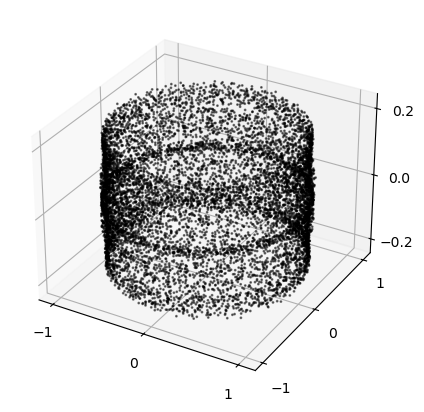

In [2]:
' Define point cloud '

# # Parameters
hydrogens = False              # whether to add hydrogens coordinates
N_conformers           = 50000 # intial number of conformers generated
N_conformers_subsample = 10000  # subsampled number of conformers

# Select a molecule
smiles = 'C1CCCCCCC1'                         # cyclooctane
# smiles = 'CC(C(=O)NC(C)C(=O)O)N'              # L-Alanyl-L-alanine
# smiles = 'CCCCC'                              # pentane
# smiles = 'OC(=O)C(Cc1ccccc1)NC(=O)C2CCCN2'    # Prolylphenylalanine
# smiles = 'CCCC'                               # butane
# smiles = 'C1CCCCC1'                           # cyclohexane
# smiles = 'CCCCC1CCCCCCC1'                     # Butylcyclooctane
# smiles = 'C1CCCCCC(=O)CCCCC1'                 # Cyclododecanone

# Generate conformers
m = rdkit.Chem.MolFromSmiles(smiles)
m = rdkit.Chem.AddHs(m)
start_time = ChronometerStart('Generate conformers... ')
cids = rdkit.Chem.rdDistGeom.EmbedMultipleConfs(m,numConfs=N_conformers,numThreads=-1,useExpTorsionAnglePrefs=False)
ChronometerStop(start_time, 's')

# Remove hydrogens
if not hydrogens: m = rdkit.Chem.RemoveHs(m)
    
# Select only one chirality cluster
start_time = ChronometerStart('Get Euclidean position of the atoms... ')
X = np.array([conformer.GetPositions().flatten() for conformer in m.GetConformers()])
ChronometerStop(start_time, 's')
X, _ = DiscardOutliers(X,contamination=0.01)
clusters = ClassifLinkage(X,n_clusters = 2)
X = X[clusters==0,:]
print('Initial point cloud has shape', np.shape(X))

# Center and normalize
X = X-np.mean(X,0)
X /= np.mean([np.linalg.norm(X[i,:]) for i in range(np.shape(X)[0])])

# Subsample with gudhi
X = np.array(gudhi.subsampling.choose_n_farthest_points(points=X, nb_points=N_conformers_subsample))
print('Subsampled point cloud has shape', np.shape(X))

# Print eigenvalues
PrintCovarianceEigenvalues(X)

# Plot point cloud
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=1, alpha=0.5);
plt.locator_params(nbins=4); plt.show(); fig.savefig('Figures/cyclooctane1.png',dpi=fig.dpi,bbox_inches='tight');

Covariance eigenvalues: [0.25, 0.25, 0.25, 0.25]
Covariance eigenvalues: [0.278, 0.275, 0.225, 0.223]


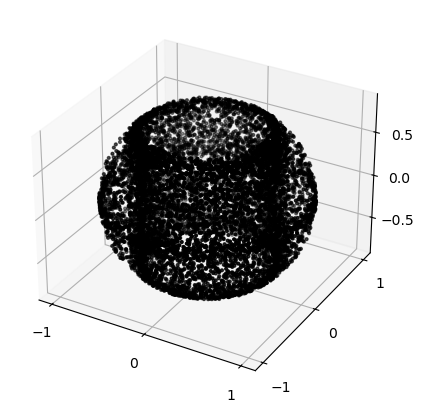

In [3]:
' Normalize data '

# Project in smaller dimension
ambient_dim = 4
Y = sklearn.decomposition.PCA(n_components=ambient_dim).fit_transform(X)

# Orthonormalization
Y, _ = Orthonormalize(Y)
PrintCovarianceEigenvalues(Y)

# Normalize pointwise
Y = np.array([x/np.linalg.norm(x) for x in Y])
PrintCovarianceEigenvalues(Y)

# Plot point cloud
Ypca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Ypca[:,0], Ypca[:,1], Ypca[:,2], c='black', s=4);
plt.locator_params(nbins=4); plt.show();

Point cloud after outliers removal has shape (8500, 4)


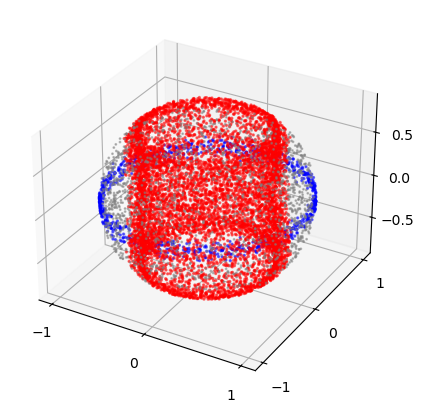

Selected cluster has shape (7504, 4)
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.014590592348382768, 0.018746600990590397, 0.10600956671089905, 0.10730737552173197]
Eigengap #2: 5.654868675345953


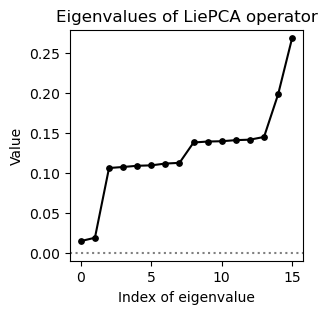

In [4]:
' Extract torus component '

# Outliers removal and hierarchical clustering
Y_rem, y_pred = DiscardOutliers(Y,contamination=0.15)
print('Point cloud after outliers removal has shape', np.shape(Y_rem))
clusters = ClassifLinkage(Y_rem,n_clusters = 2,method='single')

# Plot clusters and outliers
Indices_not_outlier = np.where(y_pred==1)[0]
Indices_outlier = np.where(y_pred==-1)[0]
Indices_cluster_0 = Indices_not_outlier[clusters==0]
Indices_cluster_1 = Indices_not_outlier[clusters==1]
Y_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(111, projection='3d'); ax.locator_params(nbins=4);
ax.scatter(Y_pca[Indices_outlier,0],Y_pca[Indices_outlier,1], Y_pca[Indices_outlier,2], c='grey', s=1, alpha=0.5)
ax.scatter(Y_pca[Indices_cluster_0,0],Y_pca[Indices_cluster_0,1], Y_pca[Indices_cluster_0,2], c='blue', s=2, alpha=0.5)
ax.scatter(Y_pca[Indices_cluster_1,0],Y_pca[Indices_cluster_1,1], Y_pca[Indices_cluster_1,2], c='red', s=2, alpha=0.5)
fig.savefig('Figures/cyclooctane2.png',dpi=fig.dpi,bbox_inches='tight');
plt.show();

# Define cluster
i_cluster = np.argmax([np.sum(clusters==0),np.sum(clusters==1)])
Z = Y_rem[clusters==i_cluster,:]
print('Selected cluster has shape', np.shape(Z))

# LiePCA
dim = 2
n_neighbors = 50
method='localPCA'
Sigma = GetLiePCAOperator(Z,n_neighbors,dim=dim,method=method,verbose=True)

# Plot LiePCA operator
fig = plt.figure(figsize=(3,3)); ax = fig.add_subplot()
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black',s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of LiePCA operator');
ax.set_xlabel('Index of eigenvalue'); ax.set_ylabel('Value'); 
fig.savefig('Figures/cyclooctane3.png',dpi=fig.dpi,bbox_inches='tight'); plt.show()

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 3
The optimal frequencies found is ((0, 1), (1, 0)) with cost 3.1401849173675503e-16
Get Hausdorff distances... It 7504/7504. Duration 0:01:25 Expected remaining time 0:00:00.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.2222
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.1038


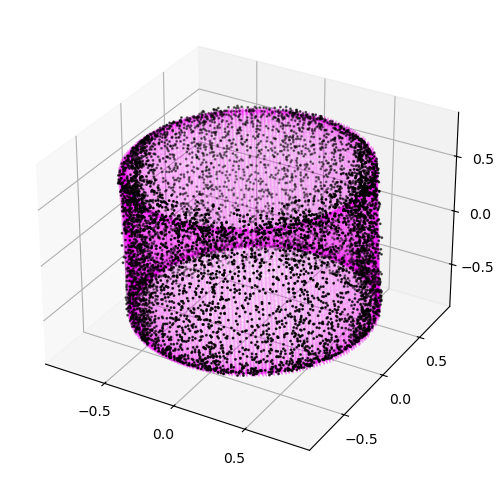

In [5]:
' LieDetect '

# Find frequencies
frequency_max = 1
method = 'NormalForm'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

' Optimize initial point '

# Find best initial point
n_points_orbit = 10
Distances = list()
msg = 'Get Hausdorff distances... '; start_time = ChronometerStart(msg)
for i in range(len(Z)):
    # Generate estimated orbit
    x = Z[i,:] 
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x)

    # Compute non-symmetric Hausdorff
    Hausdorff1 = scipy.spatial.distance.directed_hausdorff(Z, Orbit)[0]
    Hausdorff2 = scipy.spatial.distance.directed_hausdorff(Orbit, Z)[0]
    Distances.append(max(Hausdorff1,Hausdorff2))
    ChronometerTick(start_time, i, len(Z), msg)

# Generate estimated orbit
n_points_orbit = 200
x = Z[np.argmin(Distances),:]
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Z, Orbit)[0]
print('Non-symmetric Hausdorff distance from point cloud to estimated orbit:', round(Hausdorff,4))
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit,Z)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Zpca = pca.fit_transform(Z)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Zpca[:,0], Zpca[:,1], Zpca[:,2], c='black', s=1);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.05,marker="3");
plt.locator_params(nbins=4)
plt.tight_layout(); plt.show(); fig.savefig('Figures/cyclooctane4.png',dpi=fig.dpi,bbox_inches='tight');

# II. Conformers aligned

Get Euclidean position of the atoms... Execution time: 70 s.
Initial point cloud has shape (50000, 24)
Subsampled point cloud has shape (10000, 24)
Covariance eigenvalues: [0.248, 0.245, 0.112, 0.109, 0.108, 0.064, 0.063, 0.018, 0.018, 0.004, 0.003, 0.003, 0.002, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0]


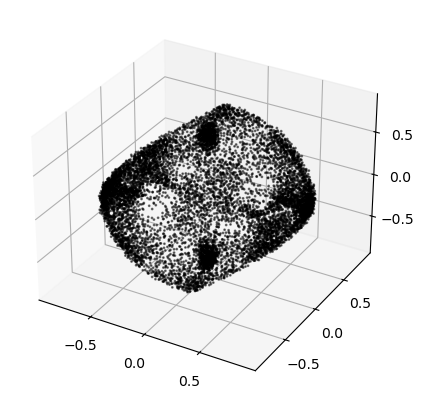

In [6]:
' Define point cloud '

# Align
rdkit.Chem.rdMolAlign.AlignMolConformers(m)

# Get positions
start_time = ChronometerStart('Get Euclidean position of the atoms... ')
X = np.array([conformer.GetPositions().flatten() for conformer in m.GetConformers()])
ChronometerStop(start_time, 's')
print('Initial point cloud has shape', np.shape(X))

# Center and normalize
X = X-np.mean(X,0)
X /= np.mean([np.linalg.norm(X[i,:]) for i in range(np.shape(X)[0])])

# Subsample with gudhi
X = np.array(gudhi.subsampling.choose_n_farthest_points(points=X, nb_points = N_conformers_subsample))
print('Subsampled point cloud has shape', np.shape(X))

# Print eigenvalues
PrintCovarianceEigenvalues(X)

# Plot point cloud
Xpca = sklearn.decomposition.PCA(n_components=3).fit_transform(X)
ax.view_init(elev=15, azim=30)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Xpca[:,0], Xpca[:,1], Xpca[:,2], c='black', s=1, alpha=0.5);
plt.locator_params(nbins=4); plt.show(); fig.savefig('Figures/cyclooctane1_align.png',dpi=fig.dpi,bbox_inches='tight');

Point cloud after outliers removal has shape (9000, 24)


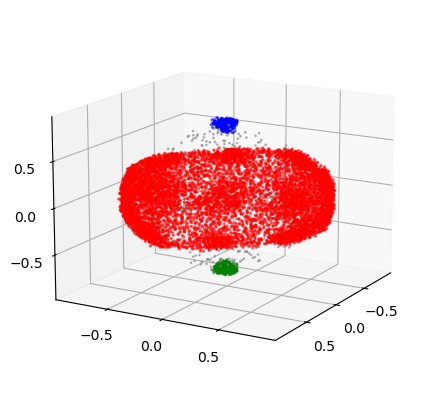

Selected cluster has shape (7909, 24)
Covariance eigenvalues: [0.297, 0.295, 0.204, 0.204]
----> Lie PCA with localPCA estimation of tangent spaces <----
First eigenvalues: [0.02110370596458795, 0.05718175729001796, 0.05824388770666416, 0.06859466148401915]
Eigengap #2: 1.0185746375589546


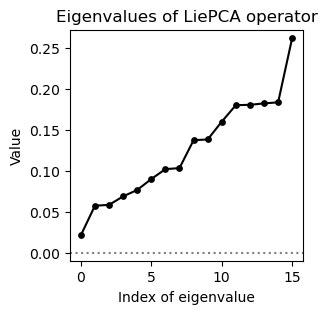

In [7]:
' Extract torus component '

Y = X

# Outliers removal and hierarchical clustering
Y_rem, y_pred = DiscardOutliers(Y,contamination=0.1)
print('Point cloud after outliers removal has shape', np.shape(Y_rem))
clusters = ClassifLinkage(Y_rem,n_clusters = 3,method='single')

# Plot clusters and outliers
Indices_not_outlier = np.where(y_pred==1)[0]
Indices_outlier = np.where(y_pred==-1)[0]
Indices_cluster_0 = Indices_not_outlier[clusters==0]
Indices_cluster_1 = Indices_not_outlier[clusters==1]
Indices_cluster_2 = Indices_not_outlier[clusters==2]
pca = sklearn.decomposition.PCA(n_components=3).fit(Y_rem)
Y_pca = pca.transform(Y)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(111, projection='3d'); ax.locator_params(nbins=4);
ax.view_init(elev=15, azim=30)
ax.scatter(Y_pca[Indices_outlier,0],Y_pca[Indices_outlier,1], Y_pca[Indices_outlier,2], c='grey', s=1, alpha=0.5)
ax.scatter(Y_pca[Indices_cluster_0,0],Y_pca[Indices_cluster_0,1], Y_pca[Indices_cluster_0,2], c='blue', s=2, alpha=0.5)
ax.scatter(Y_pca[Indices_cluster_1,0],Y_pca[Indices_cluster_1,1], Y_pca[Indices_cluster_1,2], c='green', s=2, alpha=0.5)
ax.scatter(Y_pca[Indices_cluster_2,0],Y_pca[Indices_cluster_2,1], Y_pca[Indices_cluster_2,2], c='red', s=2, alpha=0.5)
fig.savefig('Figures/cyclooctane2_align.png',dpi=fig.dpi,bbox_inches='tight');
plt.show();

# Define cluster
i_cluster = np.argmax([np.sum(clusters==0),np.sum(clusters==1),np.sum(clusters==2)])
Z = Y_rem[clusters==i_cluster,:]
print('Selected cluster has shape', np.shape(Z))

# Project in smaller dimension
ambient_dim = 4
Z = sklearn.decomposition.PCA(n_components=ambient_dim).fit_transform(Z)

# Orthonormalization
Z, _ = Orthonormalize(Z)

# Normalize pointwise
Z = np.array([x/np.linalg.norm(x) for x in Z])
PrintCovarianceEigenvalues(Z)

# LiePCA
dim = 2
n_neighbors = 50
method='localPCA'
Sigma = GetLiePCAOperator(Z,n_neighbors,dim=dim,method=method,verbose=True)

# Plot LiePCA operator
fig = plt.figure(figsize=(3,3)); ax = fig.add_subplot()
vals = np.sort(np.real(np.linalg.eig(Sigma)[0]))
ax.plot(range(len(vals)),vals,c='black'); ax.scatter(range(len(vals)), vals,c='black',s=15); 
ax.axhline(0,color='grey',linestyle='dotted'); 
ax.set_ylim((0-0.01,max(vals)+0.01)); ax.set_title('Eigenvalues of LiePCA operator');
ax.set_xlabel('Index of eigenvalue'); ax.set_ylabel('Value'); 
fig.savefig('Figures/cyclooctane3_align.png',dpi=fig.dpi,bbox_inches='tight'); plt.show()

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 3
The optimal frequencies found is ((0, 1), (1, 0)) with cost 1.5700924586837752e-16
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.8815
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.4396


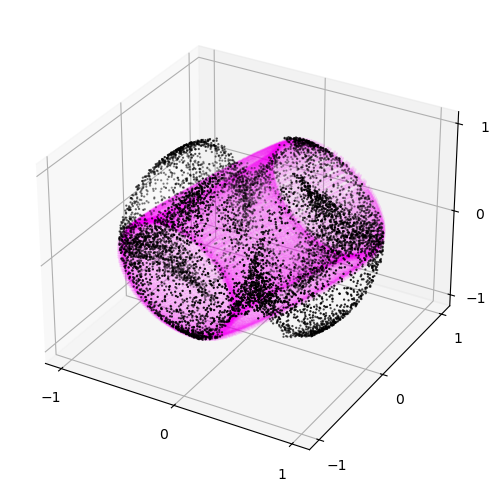

In [8]:
' LieDetect with T^2 '

# Find frequencies
dim = 2
frequency_max = 1
method = 'NormalForm'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=1)

# Generate estimated orbit
n_points_orbit = 150
x = Z[0,:]
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Z, Orbit)[0]
print('Non-symmetric Hausdorff distance from point cloud to estimated orbit:', round(Hausdorff,4))
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit,Z)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Zpca = pca.fit_transform(Z)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Zpca[:,0], Zpca[:,1], Zpca[:,2], c='black', s=0.4);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=0.5, alpha=0.05,marker="3");
plt.locator_params(nbins=4)
plt.tight_layout(); plt.show(); fig.savefig('Figures/cyclooctane4_align_torus.png',dpi=fig.dpi,bbox_inches='tight');

----> Optimization problem via NormalForm for torus group <----
Number of frequencies to test: 1
Normalized frequencies found in normal form decomposition: (0.3466424347010361, 0.9379973467257452)
The optimal frequencies found is ((1, 2),) with cost 0.10960345274860463
Frequencies ((1, 2),) - score 0.1096 (best cost #1/1)
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 1.0782
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.0801


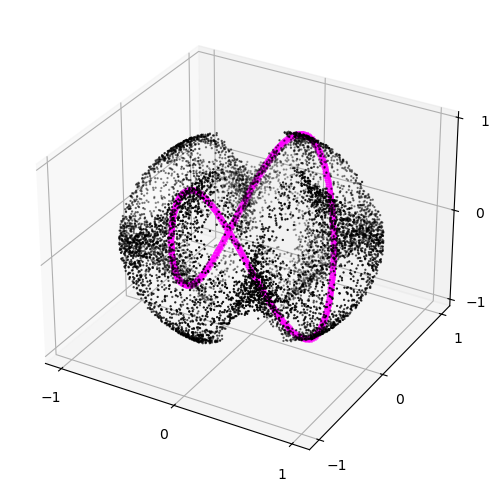

In [9]:
' LieDetect with SO(2) '

# Find frequencies
dim = 1
frequency_max = 2
method = 'NormalForm'
OptimalFrequencies, OptimalLieAlgebra = FindClosestLieAlgebra('torus', Sigma,dim,ambient_dim,frequency_max=frequency_max,
                                                              method=method,verbosity=2)

# Generate estimated orbit
n_points_orbit = 500
x = Z[1500,:]
Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

# Compute non-symmetric Hausdorff
Hausdorff = scipy.spatial.distance.directed_hausdorff(Z, Orbit)[0]
print('Non-symmetric Hausdorff distance from point cloud to estimated orbit:', round(Hausdorff,4))
Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit,Z)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', round(Hausdorff,4))

# Plot orbit
pca = sklearn.decomposition.PCA(n_components=3)
Zpca = pca.fit_transform(Z)
fig = plt.figure(figsize=(5,5)); ax = fig.add_subplot(projection='3d')
ax.scatter(Zpca[:,0], Zpca[:,1], Zpca[:,2], c='black', s=0.4);
Orbitpca = pca.transform(Orbit)
ax.plot(Orbitpca[:,0], Orbitpca[:,1], Orbitpca[:,2],c='magenta',lw=4, alpha=0.75,marker="3");
plt.locator_params(nbins=4)
plt.tight_layout(); plt.show(); fig.savefig('Figures/cyclooctane4_align.png',dpi=fig.dpi,bbox_inches='tight');

In [10]:
' Compute all Hausdorff distances '

Distances = list()
msg = 'Get Hausdorff distances... '; start_time = ChronometerStart(msg)
for i in range(len(Z)):
    # Generate estimated orbit
    n_points_orbit = 100
    x = Z[i,:] #initial point of X
    Orbit = GenerateOrbitTorus(OptimalLieAlgebra, OptimalFrequencies, n_points=n_points_orbit, x=x, method='uniform')

    # Compute non-symmetric Hausdorff
    Hausdorff = scipy.spatial.distance.directed_hausdorff(Orbit, Z)[0]
    Distances.append(Hausdorff)
    ChronometerTick(start_time, i, len(Z), msg)
    
print('\nHausdorff distance mean, std and max:', np.mean(Distances), np.std(Distances), np.max(Distances))

Get Hausdorff distances... It 7909/7909. Duration 0:00:58 Expected remaining time 0:00:00.

Hausdorff distance mean, std and max: 0.1233083888566486 0.041531639766403776 0.2974357704704927


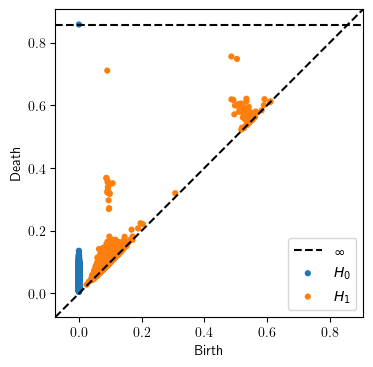

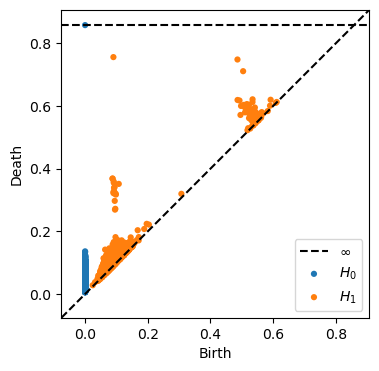

Are H1-diagrams equal? False
[0.504336   0.74849641] != [0.504336   0.71116859]
[0.4863027  0.75613463] != [0.4863027  0.74849641]
[0.09035604 0.71116859] != [0.09035604 0.75613463]


In [11]:
' Show torsion with persistent homology '

import ripser, persim

thresh = 0.8

# Persistent homology over Z/2Z
dgms = ripser.ripser(Z, coeff=2, maxdim=1, thresh=thresh)['dgms']
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot()
persim.plot_diagrams(dgms, show=True, ax=ax)
H1_0 = dgms[1]

# Persistent homology over 3/2Z

dgms = ripser.ripser(Z, coeff=3, maxdim=1, thresh=thresh)['dgms']
fig = plt.figure(figsize=(4,4)); ax = fig.add_subplot()
persim.plot_diagrams(dgms, show=True, ax=ax)
H1_1 = dgms[1]

# Show where the diagrams are different
print('Are H1-diagrams equal?', all((H1_0==H1_1).flatten().tolist()));
for i in np.where((H1_0[:,1]!=H1_1[:,1]))[0]:
    print(H1_0[i], '!=', H1_1[i])